In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

## 1. 1 次元のホテリングの T2 法


In [2]:
df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv", index_col=0
).reset_index(drop=True)


In [3]:
df.head()

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
1,F,58,161,51.0,159.0
2,F,53,161,54.0,158.0
3,M,68,177,70.0,175.0
4,F,59,157,59.0,155.0


<Axes: xlabel='weight', ylabel='Count'>

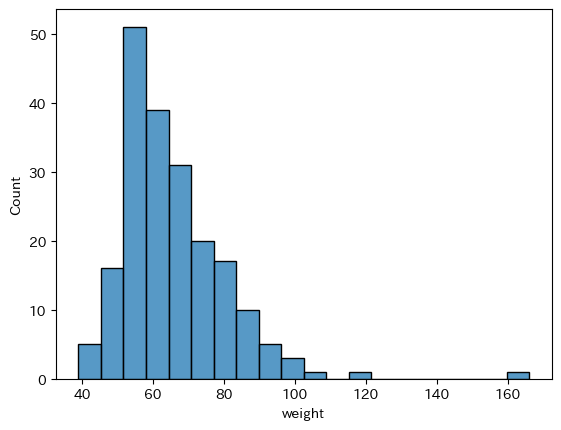

In [4]:
# 体重のヒストグラム
sns.histplot(data=df, x="weight")

In [5]:
# 標本での平均、分散(not 不偏分散)
mu = np.mean(df["weight"])
s2 = np.var(df["weight"])

print(f"mean: {mu}, variance: {s2}")


mean: 65.8, variance: 226.72


In [6]:
# 異常度の計算
df["anomaly_score"] = (df["weight"] - mu) ** 2 / s2


# 閾値の計算
th = chi2.ppf(0.99, df=1)  # カイ二乗分布の上側1%点

Text(0.5, 0, 'index')

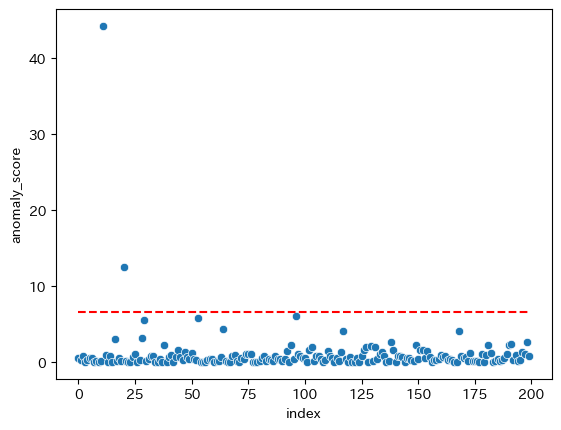

In [7]:
sns.scatterplot(x=df.index, y=df["anomaly_score"])
sns.lineplot(x=df.index, y=th, color="red", linestyle="dashed")
plt.xlabel("index")


## 2. 多次元のホテリングの T2 法


In [8]:
df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/carData/Davis.csv", index_col=0
).reset_index(drop=True)


In [9]:
df.head()

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
1,F,58,161,51.0,159.0
2,F,53,161,54.0,158.0
3,M,68,177,70.0,175.0
4,F,59,157,59.0,155.0


<Axes: xlabel='weight', ylabel='height'>

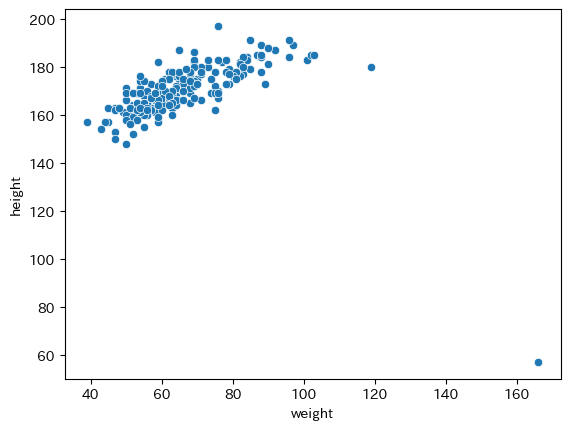

In [10]:
sns.scatterplot(data=df, x="weight", y="height")


In [11]:
# 標本平均
mx = df[["weight", "height"]].mean().values

# 中心化
Xc = df[["weight", "height"]].values - mx

# 標本共分散行列
Sx = df[["weight", "height"]].cov(ddof=0).values

# 異常度の計算(マハラノビス距離の2乗)
df["anomaly_score_2d"] = np.diag(
    (np.matmul(Xc, np.linalg.inv(Sx)) @ Xc.T)
)  # 2次形式なので、必要な対角成分のみ取り出す

# 閾値の計算
th = chi2.ppf(0.99, df=1)  # カイ二乗分布の上側1%点

Text(0.5, 0, 'index')

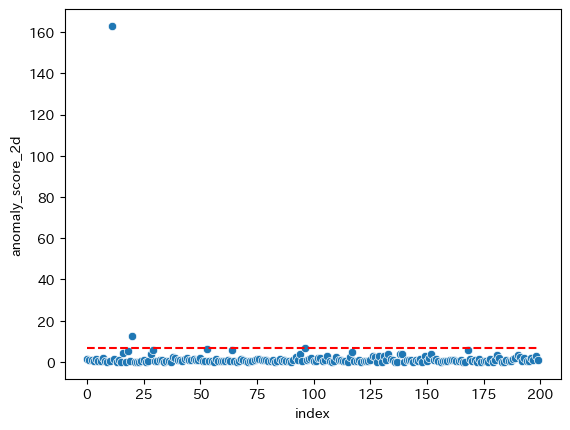

In [12]:
sns.scatterplot(x=df.index, y=df["anomaly_score_2d"])
sns.lineplot(x=df.index, y=th, color="red", linestyle="dashed")
plt.xlabel("index")


## 3. MT 法


In [13]:
df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/MASS/road.csv", index_col=0
)

In [14]:
df.head()


,deaths,drivers,popden,rural,temp,fuel
rownames,,,,,,
Alabama,968,158,64.0,66.0,62,119.0
Alaska,43,11,0.4,5.9,30,6.2
Arizona,588,91,12.0,33.0,64,65.0
Arkanas,640,92,34.0,73.0,51,74.0
Calif,4743,952,100.0,118.0,65,105.0


In [15]:
df_temp = df.copy(deep=True)

# ドライバーあたりの数に変換
df_temp = df_temp.div(df_temp["drivers"], axis=0)
df_temp.drop("drivers", axis=1, inplace=True)
# log(1+x)変換
df_temp = df_temp.apply(lambda x: np.log1p(x))

In [16]:
# 標本平均
mx = df_temp.mean().values

# 中心化
Xc = df_temp.values - mx

# 標本共分散行列
Sx = df_temp.cov(ddof=0).values

# 異常度の計算(1変数あたりの異常度
df_temp["anomaly_score_MT"] = np.diag((np.matmul(Xc, np.linalg.inv(Sx)) @ Xc.T)) / len(
    df_temp.columns
)

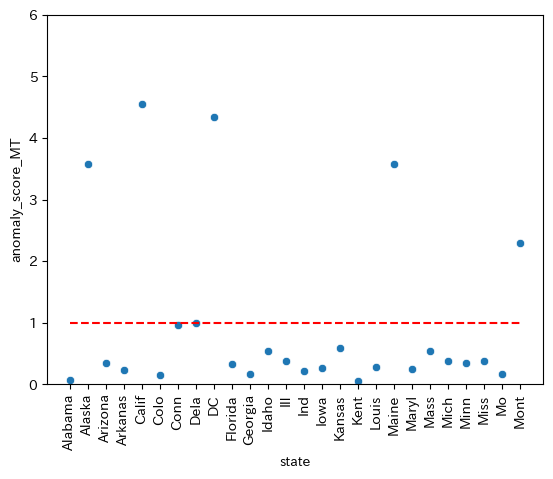

In [17]:
sns.scatterplot(x=df_temp.index, y=df_temp["anomaly_score_MT"])
sns.lineplot(x=df_temp.index, y=1.0, color="red", linestyle="dashed")
plt.ylim([0, 6])
plt.xlabel("state")
plt.xticks(rotation=90)

plt.show()

In [18]:
# SN比の計算
SN1 = 10 * np.log10(Xc**2 / np.diag(Sx))

Text(0.5, 0, 'feature')

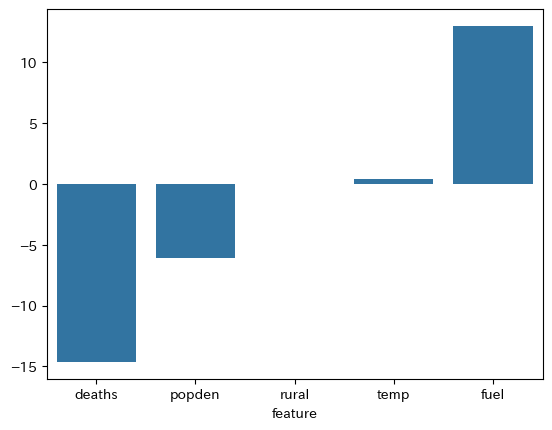

In [19]:
# CalifでのSN比のプロット
target_idx = df_temp.index.get_loc("Calif")

sns.barplot(x=df_temp.drop(["anomaly_score_MT"], axis=1).columns, y=SN1[target_idx, :])
plt.xlabel("feature")


## 4. MTGS 法


In [20]:
df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/MASS/road.csv", index_col=0
)

In [21]:
df.head()


,deaths,drivers,popden,rural,temp,fuel
rownames,,,,,,
Alabama,968,158,64.0,66.0,62,119.0
Alaska,43,11,0.4,5.9,30,6.2
Arizona,588,91,12.0,33.0,64,65.0
Arkanas,640,92,34.0,73.0,51,74.0
Calif,4743,952,100.0,118.0,65,105.0


In [22]:
df_temp = df.copy(deep=True)

# ドライバーあたりの数に変換
df_temp = df_temp.div(df_temp["drivers"], axis=0)
df_temp.drop("drivers", axis=1, inplace=True)
# log(1+x)変換
df_temp = df_temp.apply(lambda x: np.log1p(x))

In [23]:
# 標本平均
mx = df_temp.mean().values

# 中心化
Xc = df_temp.values - mx

# QR分解
q, r = np.linalg.qr(Xc)

# 標本共分散行列
Sx = np.matmul(r.T, r) / len(df_temp)

# 標本共分散行列の逆行列
Sx_inv = len(df_temp) * np.matmul(np.linalg.inv(r), np.linalg.inv(r.T))

# 異常度の計算(1変数あたりの異常度)
df_temp["anomaly_score_MTGS"] = np.diag((np.matmul(Xc, Sx_inv) @ Xc.T)) / len(
    df_temp.columns
)


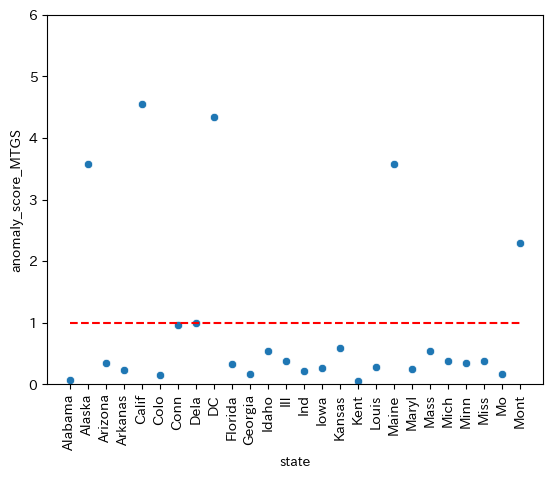

In [24]:
sns.scatterplot(x=df_temp.index, y=df_temp["anomaly_score_MTGS"])
sns.lineplot(x=df_temp.index, y=1.0, color="red", linestyle="dashed")
plt.ylim([0, 6])
plt.xlabel("state")
plt.xticks(rotation=90)

plt.show()

Text(0.5, 0, 'feature')

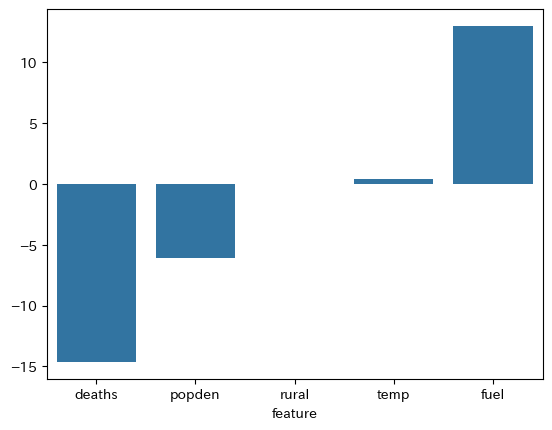

In [25]:
# CalifでのSN比のプロット
target_idx = df_temp.index.get_loc("Calif")

sns.barplot(
    x=df_temp.drop(["anomaly_score_MTGS"], axis=1).columns, y=SN1[target_idx, :]
)
plt.xlabel("feature")
